<a href="https://colab.research.google.com/github/Bduz/LSTM_encoder_decoder/blob/master/code/example_detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Bduz/LSTM_encoder_decoder.git

Cloning into 'LSTM_encoder_decoder'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 547 (delta 26), reused 8 (delta 8), pack-reused 503 (from 1)
Receiving objects: 100% (547/547), 9.12 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (272/272), done.


In [2]:
import sys
sys.path.insert(0, '/content/LSTM_encoder_decoder/code/')

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import sys
import random
import os, errno
from tqdm import trange
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import generate_dataset
#import lstm_encoder_decoder
import plotting
#matplotlib.rcParams.update({'font.size': 17})

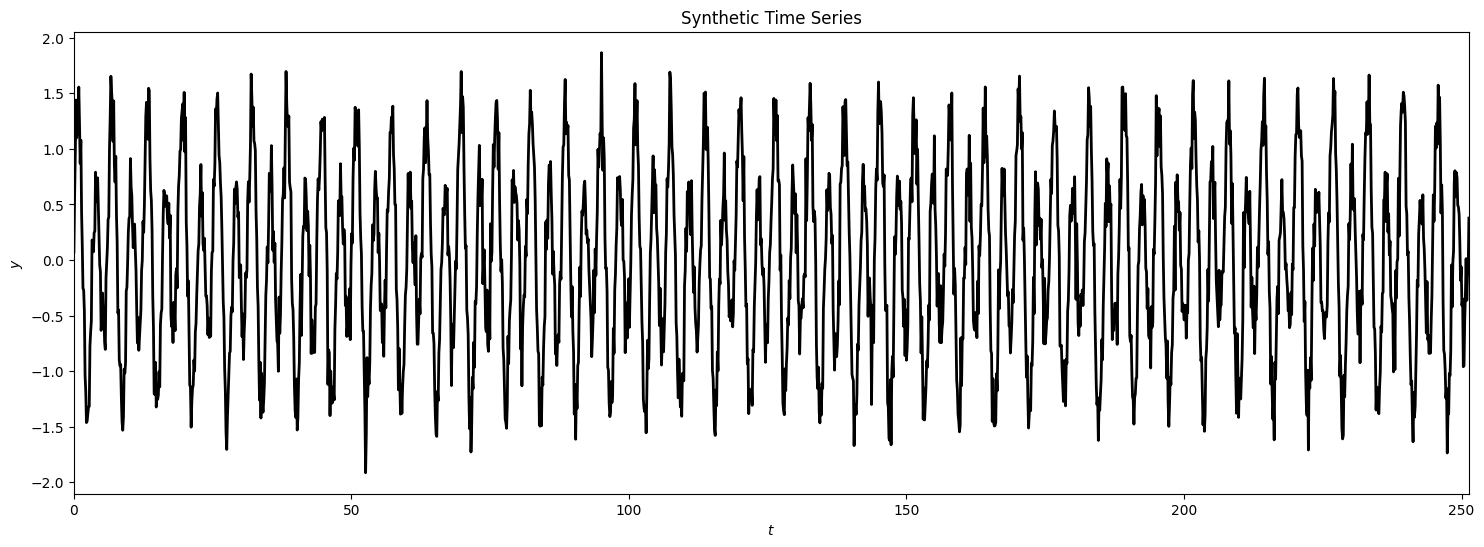

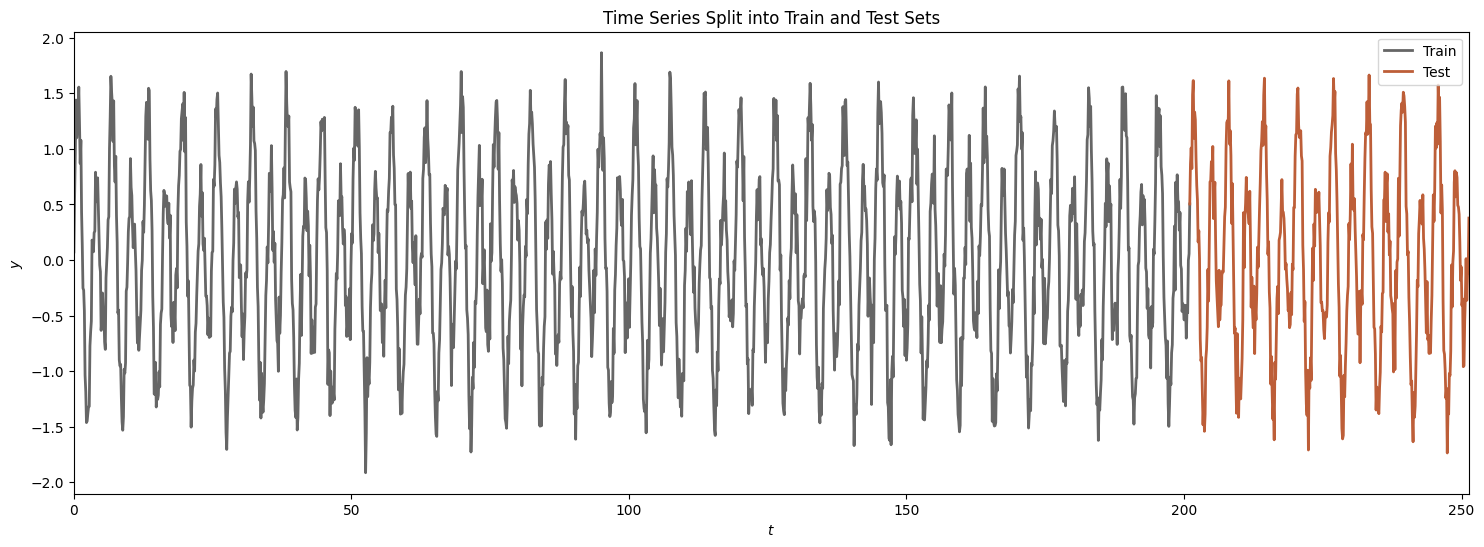

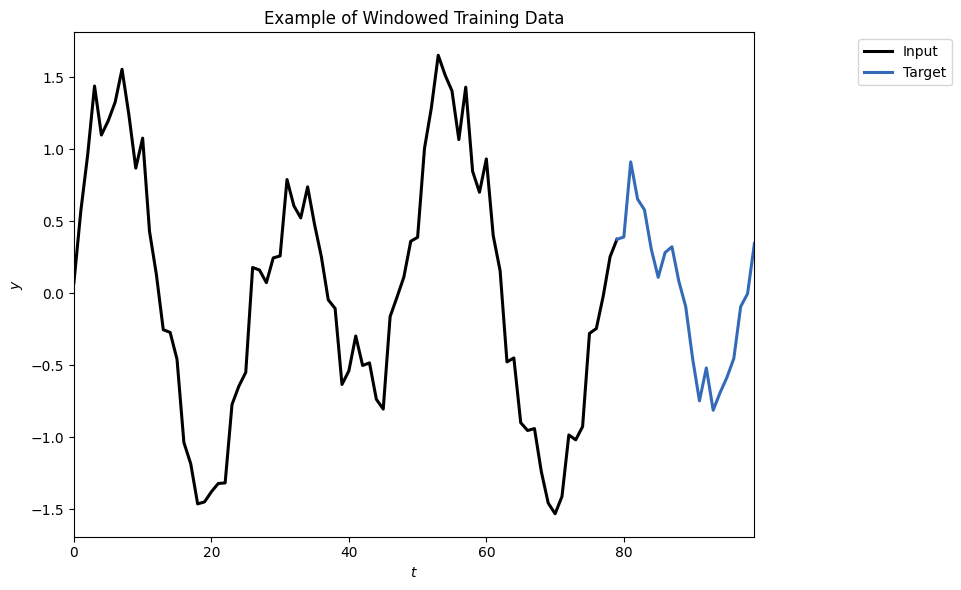

In [4]:
#----------------------------------------------------------------------------------------------------------------
# generate dataset for LSTM
t, y = generate_dataset.synthetic_data()
t_train, y_train, t_test, y_test = generate_dataset.train_test_split(t, y, split = 0.8)

# plot time series
plt.figure(figsize = (18, 6))
plt.plot(t, y, color = 'k', linewidth = 2)
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title('Synthetic Time Series')
#plt.savefig('plots/synthetic_time_series.png')

# plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(t_train, y_train, color = '0.4', linewidth = 2, label = 'Train')
plt.plot(np.concatenate([[t_train[-1]], t_test]), np.concatenate([[y_train[-1]], y_test]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([t[0], t[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
plt.savefig('train_test_split.png')

#----------------------------------------------------------------------------------------------------------------
# window dataset

# set size of input/output windows
iw = 80
ow = 20
s = 5

# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(y_train, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(y_test, input_window = iw, output_window = ow, stride = s)

# plot example of windowed data
plt.figure(figsize = (10, 6))
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('windowed_data.png')



In [16]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''

        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):

        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence
        '''

        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))

        return lstm_out, self.hidden

    def init_hidden(self, batch_size):

        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state
        '''

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''

    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''

        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):

        '''
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence

        '''

        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))

        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''

    def __init__(self, input_size, hidden_size):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):

        '''
        train lstm encoder-decoder

        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs
        : param target_len:                number of values to predict
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''

        # initialize array of losses
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:

                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively
                        else:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output

                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]

                            # predict recursively
                            else:
                                decoder_input = decoder_output

                    # compute the loss
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch
                batch_loss /= n_batches
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02

                # progress bar
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

    def predict(self, input_tensor, target_len):

        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor
        : param target_len:        number of target values to predict
        : return np_outputs:       np.array containing predicted values; prediction done recursively
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden

        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output

        np_outputs = outputs.detach().numpy()

        return np_outputs

100%|██████████| 20/20 [00:28<00:00,  1.44s/it, loss=0.041]


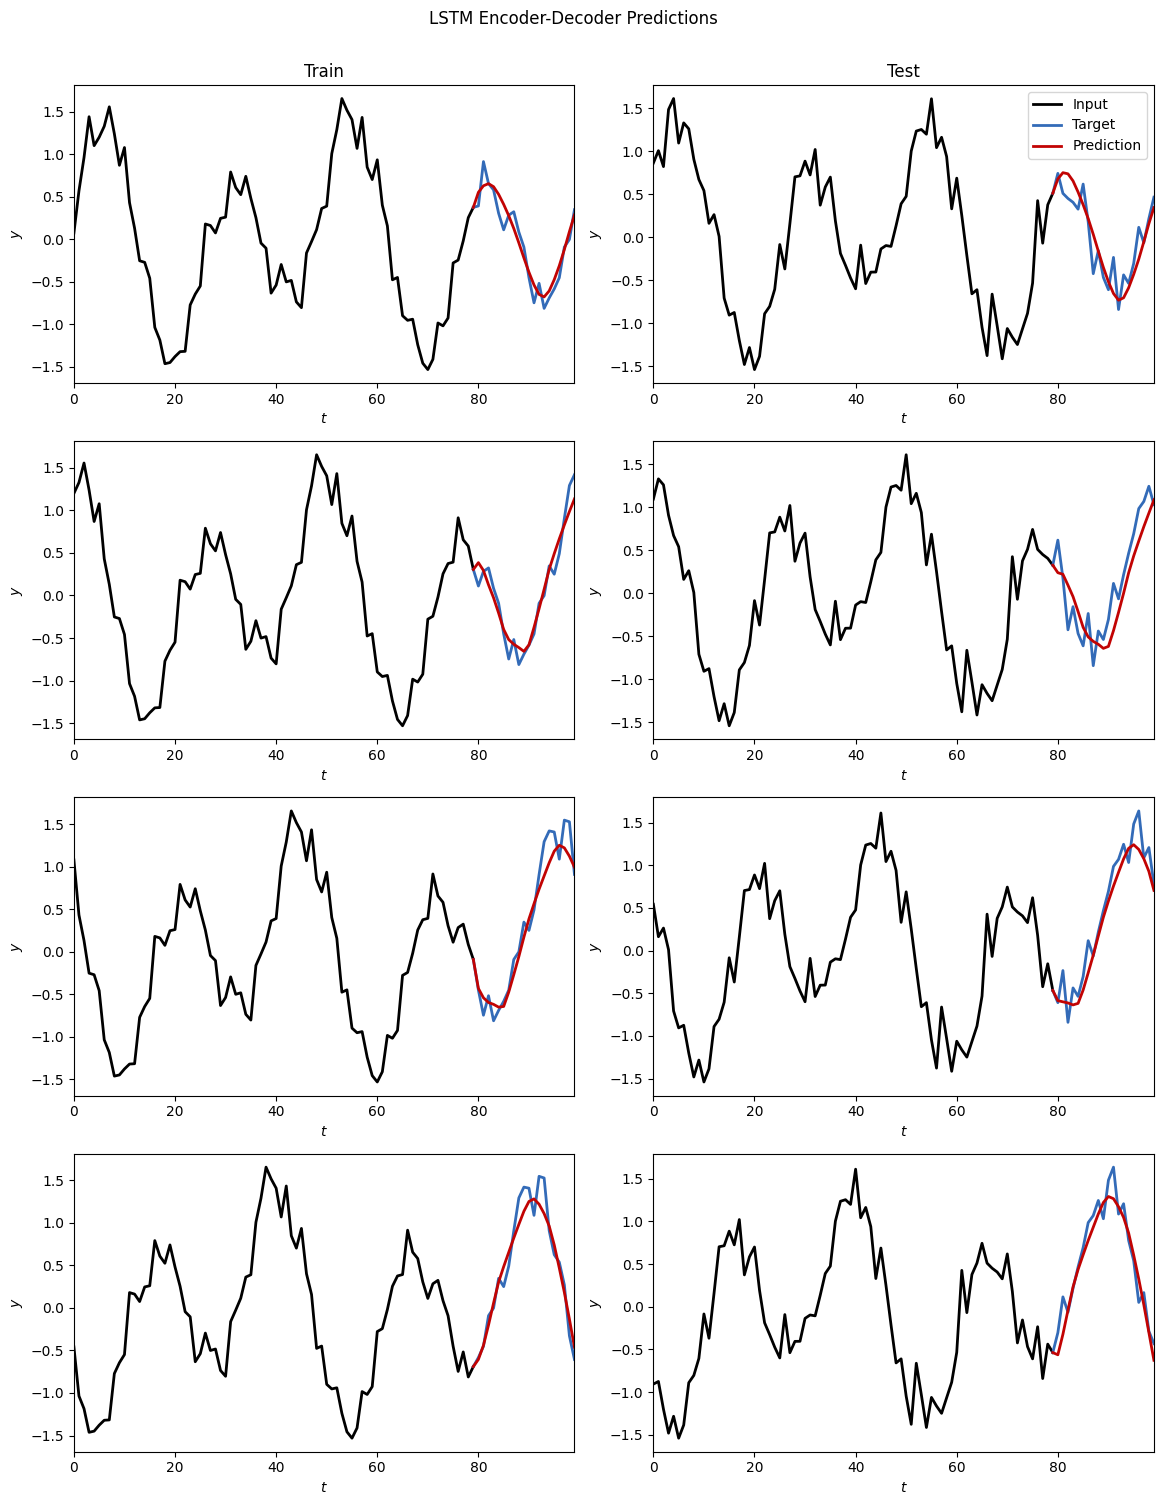

In [17]:
#----------------------------------------------------------------------------------------------------------------
# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model = lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 15)
loss = model.train_model(X_train, Y_train, n_epochs = 20, target_len = ow, batch_size = 5, training_prediction = 'recursive', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)

# plot predictions on train/test data
plotting.plot_train_test_results(model, Xtrain, Ytrain, Xtest, Ytest)


In [ ]:
plt.close('all')